### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("processed_train.csv")

In [4]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [9]:
### Your code is here
detections_info = data.groupby('HasDetections')['HasDetections'].count()
print(f'{detections_info.loc[0]}, {detections_info.loc[1]}')

99940, 20012


Произведем процедуру отложенной выборки:

In [10]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('scaler', StandardScaler()),
                ('LR',LogisticRegression())])
pipe.set_params(LR__C = 0.01)

pipe.fit(X_train, y_train)

print(f'Доля правильных ответов на тестовых данных {round(pipe.score(X_test, y_test),3)}')
print(f'Доля правильных ответов на тренировочных данных {round(pipe.score(X_train, y_train),3)}')

Доля правильных ответов на тестовых данных 0.842
Доля правильных ответов на тренировочных данных 0.841


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [32]:
from sklearn.metrics import confusion_matrix
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)
tp, tn, fp, fn = 0, 0, 0, 0
for i in range(len(pred_test)):
    predicted_value = pred_test[i]
    real_value = y_test.iloc[i]
    if real_value == 1 and predicted_value == 1:
        tp += 1
    elif real_value == 0 and predicted_value == 1:
        fp += 1
    elif real_value == 1 and predicted_value == 0:
        fn += 1
    else:
        tn += 1
print(tn, fp, fn, tp, sep = ', ')

tn = ((pred_test == 0)*(y_test == 0)).sum()
tp = ((pred_test == 1)*(y_test == 1)).sum()
fn = ((pred_test == 0)*(y_test == 1)).sum()
fp = ((pred_test == 1)*(y_test == 0)).sum()
print(tn, fp, fn, tp)

24727, 292, 4442, 527
24727 292 4442 527
[[24727   292]
 [ 4442   527]]


In [33]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred_test)
print(conf_matrix)





[[24727   292]
 [ 4442   527]]


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [34]:
### Your code is here

acc = (tp+tn)/(tp+tn+fp+fn)
print(acc.round(3))





0.842


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [36]:
from sklearn.metrics import recall_score, precision_score

recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(precision.round(3), recall.round(3), sep = ', ')
### Your code is here


print(precision_score(y_test, pred_test), recall_score(y_test, pred_test))






0.643, 0.106


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [45]:
### Your code is here
pred_probs = pipe.predict_proba(X_test)
pred_classes = [1 if prob > 0.5 else 0 for prob in pred_probs[:, 1]]
print(np.all(pred_classes==pred_test))
#print(np.all((pred_probs[:,0] < 0.5) == pred_test))





True


**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [46]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003734827264239
Recall: 	 0.12940229422418997
Threshold:	 0.45894877437903997


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [53]:
### Your code is here

precision, recall, thresholds = precision_recall_curve(y_test, pred_probs[:, 1])

ind = np.where(precision == precision[recall>0.2].max())

print(precision[ind][-1].round(3), thresholds[ind][-1].round(3), sep = ', ')



0.493, 0.331


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [54]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

Precision:	 0.16993934409375963
Recall: 	 0.9979875226403703
Threshold:	 0.021913348366453127


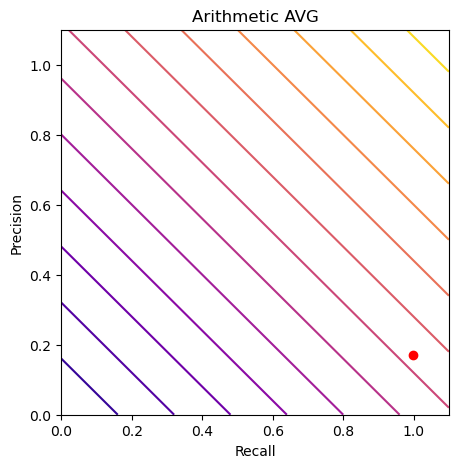

In [55]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

Precision:	 0.224
Recall: 	 0.809
Threshold:	 0.126


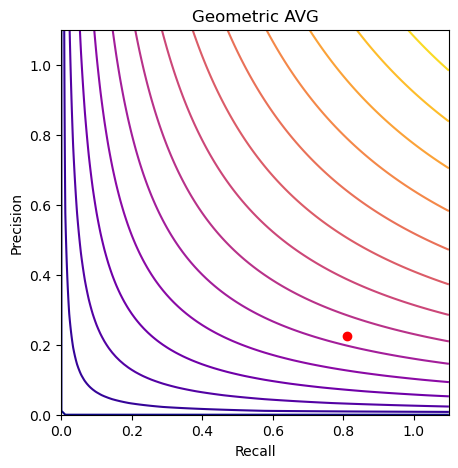

In [63]:
### Повторите для среднего геометрического
### Your code is here
metric_func = lambda x,y: (x*y)**(0.5)

geom_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[geom_idx].round(3)}")
print(f"Recall: \t {recall[geom_idx].round(3)}")
print(f"Threshold:\t {thres[geom_idx].round(3)}")

level_lines(metric_func, "Geometric AVG")
plt.plot(recall[geom_idx], precision[geom_idx], 'ro');

Precision:	 0.359
Recall: 	 0.359
Threshold:	 0.237


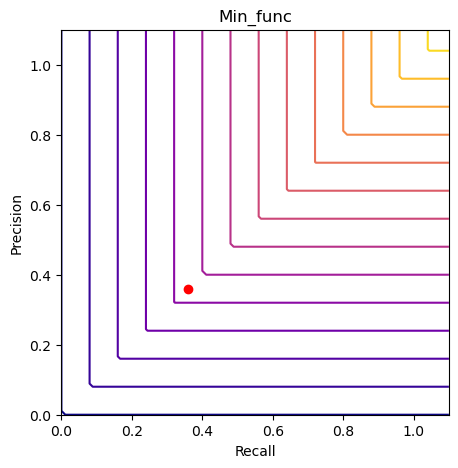

In [64]:
### Повторите для минимума
### Your code is here

### Повторите для среднего геометрического
### Your code is here
metric_func = lambda x,y: np.minimum(x,y)

min_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[min_idx].round(3)}")
print(f"Recall: \t {recall[min_idx].round(3)}")
print(f"Threshold:\t {thres[min_idx].round(3)}")

level_lines(metric_func, "Min_func")
plt.plot(recall[min_idx], precision[min_idx], 'ro');

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

In [71]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here

metric_func_1 = lambda x,y: (1+1)*x*y/(1*x+y)

indx = (metric_func_1(precision, recall)).argmax()

print(thresholds[indx].round(3), precision[indx].round(3), recall[indx].round(3), metric_func_1(precision[indx],recall[indx]).round(3), sep=', ')

0.193, 0.285, 0.524, 0.369


In [75]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

metric_func_2 = lambda x,y,beta: (1+beta)*x*y/(beta*x+y)

indx = (metric_func_2(precision,recall,0.05)).argmax()


print(thresholds[indx].round(3), precision[indx].round(3), recall[indx].round(3), metric_func_2(precision[indx],recall[indx], 0.05).round(3), sep=', ')

0.497, 0.643, 0.109, 0.521


In [76]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

metric_func_3 = lambda x,y,beta: (1+beta)*x*y/(beta*x+y)

indx = (metric_func_3(precision, recall, 4)).argmax()

print(thresholds[indx].round(3), precision[indx].round(3), recall[indx].round(3), metric_func_3(precision[indx],recall[indx], 4).round(3), sep=', ')

0.109, 0.211, 0.86, 0.532
